In [154]:
import cv2
import numpy as np
import json
import pandas as pd
from matplotlib import pyplot as plt

# Define Image Data Structure

In [155]:
class ImageData:
    def __init__(self, filename, img, actual_polygons):
        self.filename = filename
        self.img = img
        self.watershed_iou = 0
        self.improved_watershed_iou = 0
        self.kmeans_iou = 0
        self.actual_mask = np.zeros(self.img.shape[:2], np.uint8)
        self.watershed_mask = np.zeros(self.img.shape[:2], np.uint8)
        self.improved_watershed_mask = np.zeros(self.img.shape[:2], np.uint8)
        self.kmeans_mask = np.zeros(self.img.shape[:2], np.uint8)
        for index, polygon in enumerate(actual_polygons):
            cv2.fillPoly(self.actual_mask, [polygon], index + 1)

    def add_watershed_mask(self, watershed_mask):
        self.watershed_mask = cv2.bitwise_or(
            self.watershed_mask, watershed_mask)

    def add_improved_watershed_mask(self, improved_watershed_mask):
        self.improved_watershed_mask = cv2.bitwise_or(
            self.improved_watershed_mask, improved_watershed_mask)
        
    def add_kmeans_mask(self, kmeans_mask):
        self.kmeans_mask = cv2.bitwise_or(
            self.kmeans_mask, kmeans_mask)

    def show(self):
        plt.imshow(self.img)
        plt.show()

    def show_image(self, image):
        plt.imshow(image)
        plt.show()

    def show_comparison(self):
        _, ax = plt.subplots(1, 4, figsize=(12, 4))
        ax[0].imshow(self.actual_mask)
        ax[1].imshow(self.watershed_mask)
        ax[2].imshow(self.improved_watershed_mask)
        ax[3].imshow(self.kmeans_mask)
        plt.show()

    def calculate_iou(self):
        intersection = cv2.bitwise_and(
            self.actual_mask, self.watershed_mask)
        union = cv2.bitwise_or(self.actual_mask, self.watershed_mask)
        iou = cv2.countNonZero(intersection) / cv2.countNonZero(union)
        self.watershed_iou = iou

        intersection = cv2.bitwise_and(
            self.actual_mask, self.improved_watershed_mask)
        union = cv2.bitwise_or(self.actual_mask, self.improved_watershed_mask)
        iou = cv2.countNonZero(intersection) / cv2.countNonZero(union)
        self.improved_watershed_iou = iou

        intersection = cv2.bitwise_and(
            self.actual_mask, self.kmeans_mask)
        union = cv2.bitwise_or(self.actual_mask, self.kmeans_mask)
        iou = cv2.countNonZero(intersection) / cv2.countNonZero(union)
        self.kmeans_iou = iou

# Load the Datasets

In [156]:
# Initialize empty list of image data
image_datas = []

# Load labels from JSON
labels = json.load(open('datasets/labels.json'))

# Load image data
for index, image_datas_raw in enumerate(labels):
    filename = image_datas_raw['data']['image']
    img = cv2.imread('datasets/' + filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    polygons = []
    for annotation in image_datas_raw['annotations']:
        for result in annotation['result']:
            polygons.append(
                np.array(np.matmul(result['value']['points'], [
                         [img.shape[1] / 100, 0], [0, img.shape[0] / 100]]), np.int32)
            )
    image_datas.append(ImageData(filename, img, polygons))

In [157]:
# for image_data in image_datas:
#     image_data.show()

# Watershed Segmentation

In [158]:
# def im_show(img, title):
#     plt.title(title)
#     plt.imshow(img)
#     plt.show()


def im_show(img, title):
    return


for image_data in image_datas:
    image = image_data.img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    im_show(gray, 'gray')

    # Menggunakan threshold untuk menentukan batas objek
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)

    # Menerapkan transformasi morfologi untuk membersihkan gambar
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Mengaplikasikan operasi sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    im_show(sure_bg, 'sure_bg')

    # Menemukan sure foreground area menggunakan transformasi distansi
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Mencari unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    im_show(sure_fg, 'sure_fg')
    im_show(unknown, 'unknown')

    # Membuat label untuk komponen yang terhubung
    ret, markers = cv2.connectedComponents(sure_fg)

    im_show(markers, 'markers connected components')

    # Menambahkan 1 ke setiap label sehingga menjadi 1, bukan 0
    markers = markers + 1

    im_show(markers, 'markers + 1')

    # Menandai area tidak pasti dengan 0
    markers[unknown == 255] = 0

    im_show(markers, 'markers unknown')

    # Menerapkan algoritma watershed
    cv2.watershed(image, markers)
    markers = markers - 1
    markers[markers < 0] = 0
    markers[markers != 0] = 254
    markers[markers == 0] = 1
    markers[markers == 254] = 0

    im_show(markers, 'markers watershed')
    im_show(image, 'image watershed')

    image_data.add_watershed_mask(np.array(markers, np.uint8))

# Improved Watershed Segmentation

In [159]:
def im_show(img, title):
    return


for image_data in image_datas:
    image = image_data.img.copy()

    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    im_show(gray, 'gray')

    # Apply GaussianBlur untuk mengurangi noise dan improve adaptive thresholding
    # gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Convert the image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # # Extract the L channel (luminance)
    l_channel = lab_image[:, :, 0]

    # Menggunakan threshold untuk menentukan batas objek
    ret, thresh = cv2.threshold(
        l_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Menerapkan transformasi morfologi untuk membersihkan gambar
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    close = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=2)


    # Melakukan morphological reconstruction untuk improve marker
    # marker = cv2.dilate(opening, kernel, iterations=3)
    # marker = cv2.erode(marker, kernel, iterations=2)

    # Mengaplikasikan operasi sure background area
    sure_bg = cv2.dilate(close, kernel, iterations=3)

    im_show(sure_bg, 'sure_bg')

    # Menemukan sure foreground area menggunakan transformasi distansi
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(
        dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Mencari unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    im_show(sure_fg, 'sure_fg')
    im_show(unknown, 'unknown')

    # Membuat label untuk komponen yang terhubung
    ret, markers = cv2.connectedComponents(sure_fg)

    im_show(markers, 'markers connected components')

    # Menambahkan 1 ke setiap label sehingga menjadi 1, bukan 0
    markers = markers + 1

    im_show(markers, 'markers + 1')

    # Menandai area tidak pasti dengan 0
    markers[unknown == 255] = 0

    im_show(markers, 'markers unknown')

    # Menerapkan algoritma watershed
    cv2.watershed(image, markers)
    markers = markers - 1
    markers[markers < 0] = 0

    im_show(markers, 'markers watershed')
    im_show(image, 'image watershed')

    image_data.add_improved_watershed_mask(np.array(markers, np.uint8))

# KMeans

In [160]:
# def remove_shadows(image):
#     # Convert the image to LAB color space
#     lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

#     # Split the LAB image into channels
#     l, a, b = cv2.split(lab)

#     # Threshold the L-channel to identify dark regions (potential shadows)
#     _, shadow_mask = cv2.threshold(l, 50, 255, cv2.THRESH_BINARY)

#     # Optional: Use morphological operations to improve the shadow mask
#     kernel = np.ones((5, 5), np.uint8)
#     shadow_mask = cv2.morphologyEx(shadow_mask, cv2.MORPH_CLOSE, kernel)

#     # Create a mask of the non-shadow areas
#     non_shadow_mask = cv2.bitwise_not(shadow_mask)

#     # Extract the chromatic information (a and b channels) from LAB
#     a_non_shadow = cv2.bitwise_and(a, a, mask=non_shadow_mask)
#     b_non_shadow = cv2.bitwise_and(b, b, mask=non_shadow_mask)

#     # Merge the non-shadow chromatic channels with the original L-channel
#     lab_no_shadow = cv2.merge([l, a_non_shadow, b_non_shadow])

#     # Convert the LAB image back to BGR color space
#     image_no_shadow = cv2.cvtColor(lab_no_shadow, cv2.COLOR_LAB2BGR)

#     return image_no_shadow

def kmeans_segmentation(image, k):
    # Flatten the image into a 2D array of pixels
    pixels = image.reshape((-1, 3))

    # Convert to float32 for K-means
    pixels = np.float32(pixels)

    # Define criteria and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape the labels back to the original image shape
    markers = labels.reshape(image.shape[:2])
    
    return markers


def im_show(img, title):
    return


for image_data in image_datas:
    image = image_data.img.copy()

    # image_no_shadow = remove_shadows(image)
    markers = kmeans_segmentation(image, 2)


    # Ensure background has a value of 0
    markers[markers != 0] = 255

    markers[markers < 0] = 0

    image_data.add_kmeans_mask(np.array(markers, np.uint8))

# Visualize the Results

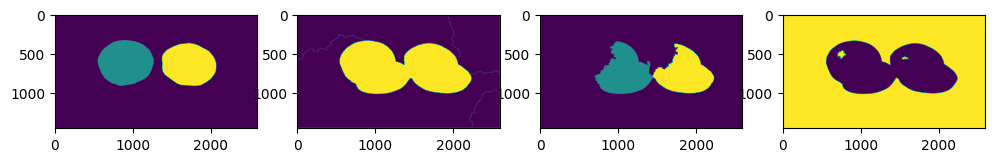

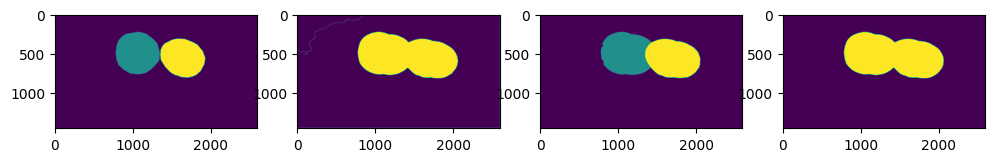

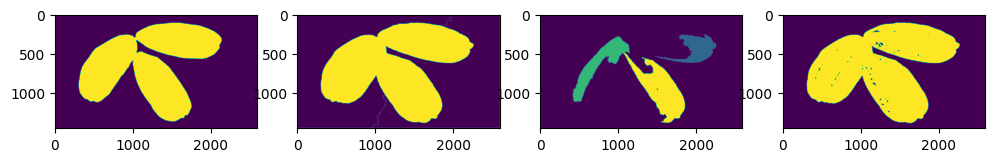

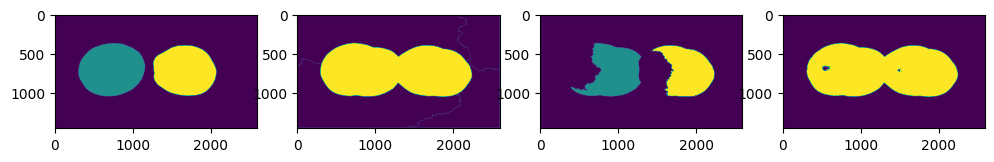

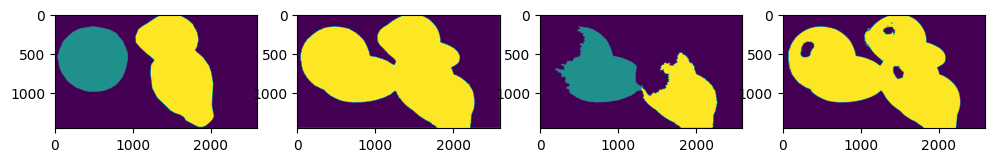

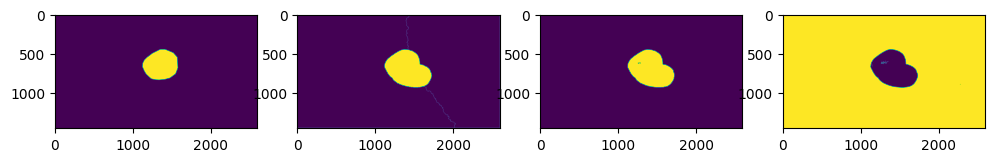

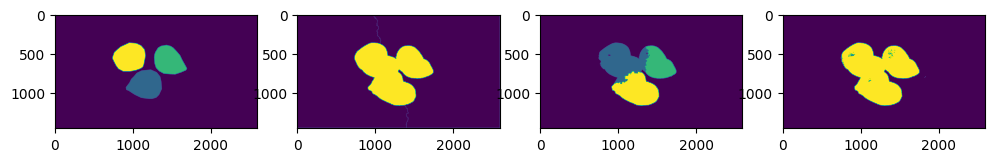

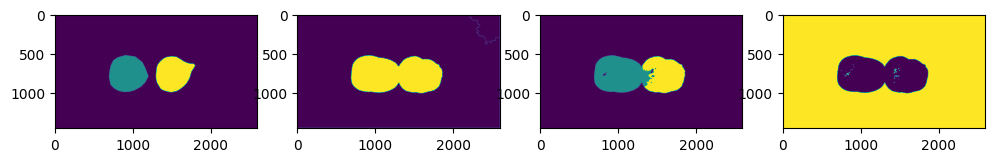

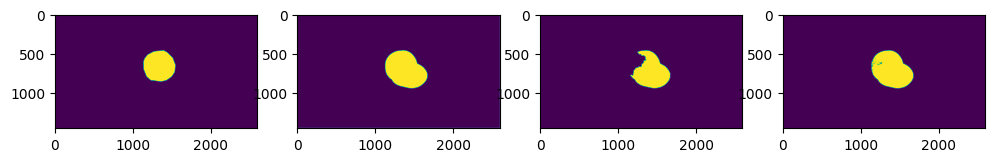

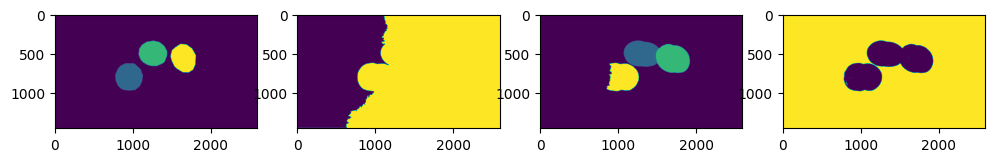

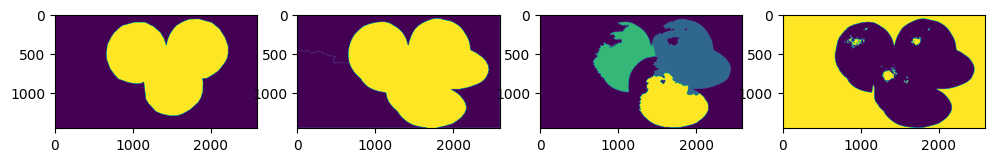

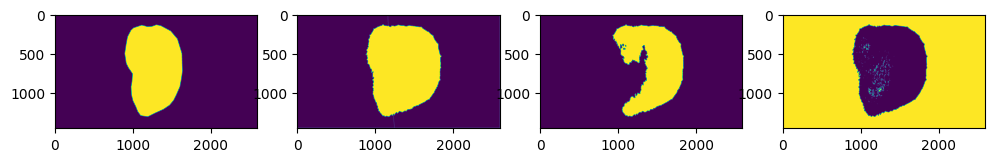

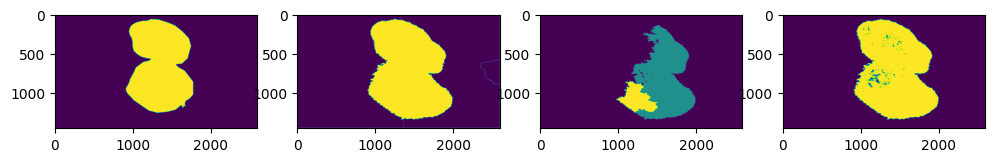

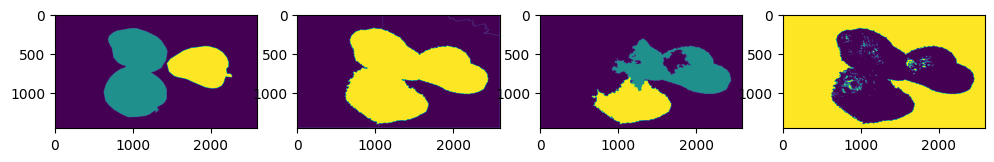

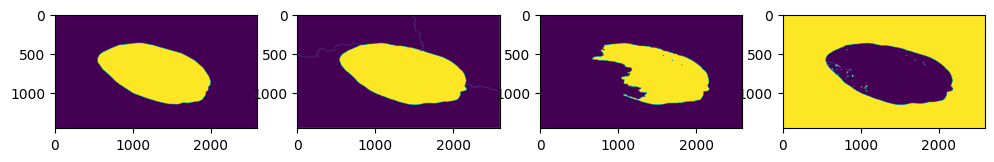

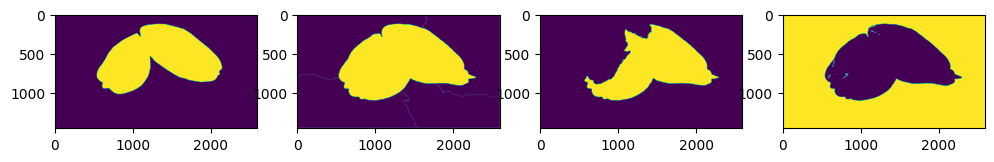

In [161]:
for image_data in image_datas:
    image_data.show_comparison()

In [162]:
iou_results = []
for image_data in image_datas:
    image_data.calculate_iou()
    iou_results.append([image_data.filename, 
                        image_data.watershed_iou,
                        image_data.improved_watershed_iou])

df = pd.DataFrame(iou_results, columns=[
                  'Filename', 'Watershed IoU', 'Improved Watershed IoU'])

df

,Filename,Watershed IoU,Improved Watershed IoU
0,ambarella044.JPG,0.374890,0.465146
1,sapodilla041.JPG,0.412672,0.810632
2,star_fruit050.JPG,0.819579,0.176707
3,ambarella041.JPG,0.416913,0.471219
4,avocado168.JPG,0.294128,0.384123
5,salak002.JPG,0.631862,0.660120
6,salak006.JPG,0.491734,0.673418
7,salak163.JPG,0.386668,0.707699
8,sapodilla122.JPG,0.650539,0.495650
9,sapodilla127.JPG,0.076876,0.402596
